In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import urllib.request
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# DATA LOADING 

In [ ]:
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from sklearn.utils import shuffle

Using TensorFlow backend.


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
label_dir = '/content/drive/My Drive/DeepLearning/Project/Hyderabad_patches/Final_ProjectData/labels.csv'
data_dir = '/content/drive/My Drive/DeepLearning/Project/Hyderabad_patches/Final_ProjectData/Data/'
models_dir = '/content/drive/My Drive/DeepLearning/Project/Hyderabad_patches/Step2/Models/'


In [ ]:
df = pd.read_csv(label_dir)
df.head()

,ImageName,High Building Density,Moderate Building Density,Low Building Density,Regular Layout,Irregular Layout,Dense Greenery,Sparse Greenery,Very Sparse Greenery,Grass,Trees,Large Buildings,Exposed Soil
0,Hyderabad_1-1tile_10800-2200.png,0,0,1,0,1,0,1,0,0,1,0,1
1,Hyderabad_1-1tile_11000-11800.png,1,0,0,1,0,0,0,1,0,0,0,0
2,Hyderabad_1-1tile_10800-6800.png,0,0,1,0,1,0,0,1,0,0,0,1
3,Hyderabad_1-1tile_10600-11000.png,0,1,0,0,1,0,1,0,1,1,0,1
4,Hyderabad_1-1tile_11000-14200.png,1,0,0,0,1,0,0,1,0,0,0,0


In [ ]:
image_names , Original_labels =  df.columns[0] , list(df.columns[1:])

In [ ]:
print(image_names)
print(Original_labels)

ImageName
['High Building Density', 'Moderate Building Density', 'Low Building Density', 'Regular Layout', 'Irregular Layout', 'Dense Greenery', 'Sparse Greenery', 'Very Sparse Greenery', 'Grass', 'Trees', 'Large Buildings', 'Exposed Soil']


In [ ]:
df = shuffle(df)
df.reset_index(inplace=True, drop=True)

In [ ]:
df_train, df_val, df_test = np.split(df, [int(.8 * len(df)), int(.9 * len(df))])

In [ ]:
print("Total Data" , len(df))
print("Train Data:" , len(df_train),", Val Data:" , len(df_val)," Test Data:" , len(df_test))

Total Data 5078
Train Data: 4062 , Val Data: 508  Test Data: 508


In [ ]:
datagen=ImageDataGenerator(rescale=1./255.)
val_datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
              dataframe=df_train,
              directory=data_dir,
              x_col=image_names,
              y_col=Original_labels,
              batch_size=32,
              seed=42,
              shuffle=True,
              class_mode="raw")


valid_generator=val_datagen.flow_from_dataframe(
              dataframe=df_val,
              directory=data_dir,
              x_col=image_names,
              y_col=Original_labels,
              batch_size=32,
              seed=42,
              shuffle=True,
              class_mode="raw")

test_generator=test_datagen.flow_from_dataframe(
              dataframe=df_test,
              directory=data_dir,
              x_col=image_names,
              y_col=Original_labels,
              batch_size=32,
              seed=42,
              shuffle=True,
              class_mode="raw")

Found 4062 validated image filenames.
Found 508 validated image filenames.
Found 508 validated image filenames.


In [ ]:
# Simple Model 
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(256,256,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='sigmoid'))
model.compile(optimizers.SGD(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

Epoch 1/10
126/126 [==============================] - 939s 7s/step - loss: 0.5865 - accuracy: 0.6993 - val_loss: 0.5760 - val_accuracy: 0.7290
Epoch 2/10
126/126 [==============================] - 26s 204ms/step - loss: 0.5346 - accuracy: 0.7278 - val_loss: 0.5487 - val_accuracy: 0.7449
Epoch 3/10
126/126 [==============================] - 25s 202ms/step - loss: 0.5058 - accuracy: 0.7471 - val_loss: 0.4925 - val_accuracy: 0.7647
Epoch 4/10
126/126 [==============================] - 25s 201ms/step - loss: 0.4866 - accuracy: 0.7619 - val_loss: 0.4885 - val_accuracy: 0.7544
Epoch 5/10
126/126 [==============================] - 25s 200ms/step - loss: 0.4737 - accuracy: 0.7688 - val_loss: 0.4431 - val_accuracy: 0.7574
Epoch 6/10
126/126 [==============================] - 25s 202ms/step - loss: 0.4658 - accuracy: 0.7756 - val_loss: 0.4610 - val_accuracy: 0.7897
Epoch 7/10
126/126 [==============================] - 26s 204ms/step - loss: 0.4541 - accuracy: 0.7822 - val_loss: 0.4241 - val_accu

In [ ]:
# Load weights
model.load_weights(models_dir+'model_full_01.h5')

In [ ]:
model.save_weights('/content/drive/My Drive/DeepLearning/Project/Hyderabad_patches/Step2/Models/model_full_01.h5')

In [ ]:
scores = model.evaluate(test_generator)
print("Accuracy on test Data: " ,scores[1]*100)

16/16 [==============================] - 108s 7s/step
Accuracy on test Data:  79.23228144645691


In [ ]:
# Again Training
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30
)

Epoch 1/30
126/126 [==============================] - 25s 202ms/step - loss: 0.4133 - accuracy: 0.8055 - val_loss: 0.3935 - val_accuracy: 0.7962
Epoch 2/30
126/126 [==============================] - 26s 208ms/step - loss: 0.3990 - accuracy: 0.8139 - val_loss: 0.4753 - val_accuracy: 0.7873
Epoch 3/30
126/126 [==============================] - 26s 205ms/step - loss: 0.3865 - accuracy: 0.8230 - val_loss: 0.4605 - val_accuracy: 0.7983
Epoch 4/30
126/126 [==============================] - 26s 209ms/step - loss: 0.3663 - accuracy: 0.8352 - val_loss: 0.4011 - val_accuracy: 0.7939
Epoch 5/30
126/126 [==============================] - 26s 203ms/step - loss: 0.3509 - accuracy: 0.8424 - val_loss: 0.4407 - val_accuracy: 0.7869
Epoch 6/30
126/126 [==============================] - 25s 201ms/step - loss: 0.3332 - accuracy: 0.8503 - val_loss: 0.4570 - val_accuracy: 0.7796
Epoch 7/30
126/126 [==============================] - 25s 201ms/step - loss: 0.3170 - accuracy: 0.8615 - val_loss: 0.4894 - val_ac

In [ ]:
model.save_weights(models_dir+'model_full_02.h5')

In [ ]:
scores = model.evaluate(test_generator)
print("Accuracy on test Data: " ,scores[1]*100)

16/16 [==============================] - 166s 10s/step
Accuracy on test Data:  82.28346705436707


In [ ]:
#Prediction 
test_generator.reset()
pred=model.predict_generator(test_generator,
            #steps=STEP_SIZE_TEST,
            verbose=1)

16/16 [==============================] - 4s 227ms/step


In [ ]:
# To Save Prediction
pred_bool = (pred >0.5)

predictions = pred_bool.astype(int)
columns= Original_labels
#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=columns)
results[image_names]= test_generator.filenames
ordered_cols=[image_names]+columns
results=results[ordered_cols]#To get the same column order


Peshawar_1-1tile_15200-7600.png
True Labels: 
 ['High Building Density', 'Irregular Layout', 'Trees', 'Exposed Soil']
Predicted Labels: 
 ['Irregular Layout', 'Grass', 'Trees', 'Exposed Soil']


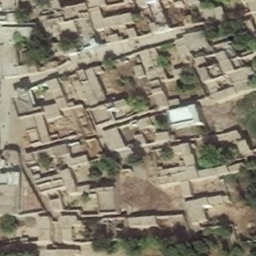

In [ ]:
 # Printing Test Image with its predicted Labels
index = 300
print(df_test.iloc[index][image_names])
true_labels = dict(df_test.iloc[index][df_test.iloc[index]==1])
print("True Labels: \n",list(true_labels.keys()))


pred_labels = dict(results.iloc[index][results.iloc[index]==1])
print("Predicted Labels: \n",list(pred_labels.keys()))

image_dir = data_dir + results.iloc[index][image_names]  
im = Image.open(image_dir)  
im